In [4]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [6]:
df = pd.read_csv(r'C:\Users\off1c\OneDrive\Desktop\Datsets\Toxic_Comments\train.csv')

In [8]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [8]:
df.iloc[0]['comment_text']

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [10]:
df[df.columns[2:]].iloc[3]

toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 3, dtype: int64

In [12]:
df[df['toxic']==1].head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0


In [14]:
df.iloc[6]['comment_text']

'COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK'

In [10]:
# Preprocessing
# Used to tokenize or mapping our data
from tensorflow.keras.layers import TextVectorization

In [12]:
X=df['comment_text']
y = df[df.columns[2:]].values

In [14]:
MAX_FEATURES = 200000 #no. of words in the vocab
SEQUENCE_LENGTH = 1800

In [16]:
# Text vectorization
vectorizer = TextVectorization(max_tokens=MAX_FEATURES, output_sequence_length=SEQUENCE_LENGTH, output_mode='int')
vectorizer.adapt(X.values)
vectorized_text = vectorizer(X.values)

In [18]:
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]], dtype=int64)>

In [20]:
# Build data pipeline
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache().shuffle(160000).batch(16).prefetch(8)

In [22]:
# Split dataset into train, validation, and test sets
train_size = int(len(dataset) * 0.7)
val_size = int(len(dataset) * 0.2)
test_size = len(dataset) - train_size - val_size

train = dataset.take(train_size)
val = dataset.skip(train_size).take(val_size)
test = dataset.skip(train_size + val_size)

In [24]:
# Create Sequential Model
from tensorflow.keras.models import Sequential

In [26]:
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [28]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [30]:
model = Sequential([
    Embedding(MAX_FEATURES + 1, 32),  # Embedding layer
    Bidirectional(LSTM(32, activation='tanh')),  # Bidirectional LSTM
    Dense(128, activation='relu'),  # Dense layers
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(6, activation='sigmoid')  # Output layer for multi-label classification
])

In [32]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [34]:
eps = 1
history = model.fit(
    train,
    validation_data=val,
    epochs=eps,
    batch_size=1024 
)

6981/6981 ━━━━━━━━━━━━━━━━━━━━ 7288s 1s/step - accuracy: 0.9515 - loss: 0.0855 - val_accuracy: 0.9922 - val_loss: 0.0449


In [36]:
history.history 

{'accuracy': [0.9765613675117493],
 'loss': [0.06270036101341248],
 'val_accuracy': [0.9921640157699585],
 'val_loss': [0.044853247702121735]}

In [38]:
import matplotlib.pyplot as plt

<Figure size 800x500 with 0 Axes>

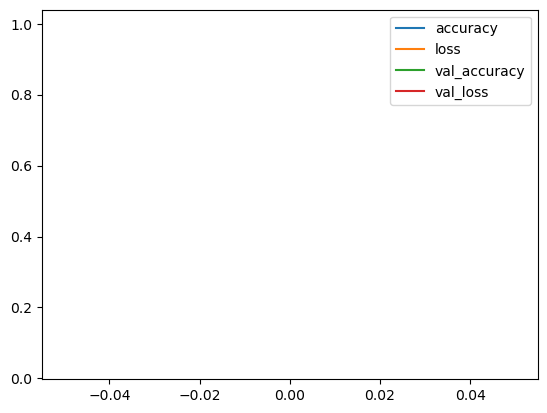

In [40]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [42]:
# Make Prediction

In [44]:
input_text = vectorizer('You freaking suck!')

In [46]:
batch = test.as_numpy_iterator().next()

In [48]:
res = model.predict(np.expand_dims(input_text,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step


In [50]:
# Evaluate Model

In [52]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [54]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [56]:
for batch in test.as_numpy_iterator():
    X_true, y_true = batch
    yhat = model.predict(X_true)

    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

In [58]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.8095556497573853, Recall:0.7013024687767029, Accuracy: 0.4934934973716736


In [60]:
model.save('toxicity.h5')

In [62]:
model = tf.keras.models.load_model('toxicity.h5')

In [64]:
input_str = vectorizer('hey i freaken hate you!')

In [66]:
res = model.predict(np.expand_dims(input_str,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


In [68]:
res

array([[0.89363915, 0.02933974, 0.63717234, 0.0190614 , 0.48835728,
        0.04068819]], dtype=float32)

In [70]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)

    text = ''
    for idx, col in enumerate(df.columns[2:-1]):
        text+='{}: {}\n'.format(col, results[0][idx]>0.5)
    return text

In [72]:
!pip install gradio

In [74]:
import gradio as gr

In [78]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.Textbox(lines=2, placeholder='Comment to Score'),
                        outputs='text')

In [80]:
interface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://c07b4848f7a78044a7.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
